## usage data

In [1]:
from sqlalchemy import create_engine, types
from datetime import datetime, timedelta
from IPython.display import display
import matplotlib.pyplot as plt
import reliant_scrape as rs
import mysql.connector
import pandas as pd
import numpy as np
import pprint
import boto3
import boto
import json
import sys
import os

base = os.path.join('C:\\', 'Users', 'steve', 'Documents', 'reliant-scrape')
data = os.path.join(base, 'data')
pp = pprint.PrettyPrinter(indent = 1)
print('imported modules')

imported modules


## read data

In [3]:
print(os.listdir(data))

['daily_usage_08312020.csv', 'daily_usage_09052020.csv', 'daily_usage_09092020.csv', 'daily_usage_09132020.csv', 'daily_usage_09212020.csv', 'daily_usage_09232020.csv', 'master_energy_usage_091520.csv']


In [4]:
os.chdir(data)
use1 = pd.read_csv('daily_usage_08312020.csv', index_col = 0)
use1.head()

,Usage (kWh),Cost ($),Hi,Low
Date,,,,
2020-08-25 00:00:00,1.1,0.13,94,79
2020-08-25 01:00:00,1.2,0.14,94,79
2020-08-25 02:00:00,1.0,0.12,94,79
2020-08-25 03:00:00,1.0,0.12,94,79
2020-08-25 04:00:00,1.5,0.18,94,79


In [5]:
use2 = pd.read_csv('daily_usage_09052020.csv', index_col = 0)
use2.head()

,Usage (kWh),Cost ($),Hi,Low
Date,,,,
2020-08-31 00:00:00,1.0,0.12,96,83
2020-08-31 01:00:00,0.9,0.11,96,83
2020-08-31 02:00:00,0.9,0.11,96,83
2020-08-31 03:00:00,0.9,0.10,96,83
2020-08-31 04:00:00,0.9,0.10,96,83


In [6]:
use3 = pd.read_csv('daily_usage_09132020.csv', index_col = 0)
use3.head()

,Usage (kWh),Cost ($),Hi,Low
Date,,,,
2020-09-07 00:00:00,3.9,0.46,93,78
2020-09-07 01:00:00,3.5,0.41,93,78
2020-09-07 02:00:00,3.1,0.37,93,78
2020-09-07 03:00:00,1.7,0.20,93,78
2020-09-07 04:00:00,2.0,0.24,93,78


In [7]:
use4 = pd.read_csv('daily_usage_09212020.csv', index_col = 0)
use4.head()

,Usage (kWh),Cost ($),Hi,Low
Date,,,,
2020-09-14 00:00:00,2.1,0.25,89,79
2020-09-14 01:00:00,1.8,0.22,89,79
2020-09-14 02:00:00,1.7,0.20,89,79
2020-09-14 03:00:00,1.5,0.18,89,79
2020-09-14 04:00:00,1.4,0.17,89,79


## create master df

In [8]:
master = pd.concat([use1, use2, use3, use4], axis = 0)
master.head()

,Usage (kWh),Cost ($),Hi,Low
Date,,,,
2020-08-25 00:00:00,1.1,0.13,94,79
2020-08-25 01:00:00,1.2,0.14,94,79
2020-08-25 02:00:00,1.0,0.12,94,79
2020-08-25 03:00:00,1.0,0.12,94,79
2020-08-25 04:00:00,1.5,0.18,94,79


In [9]:
master.tail()

,Usage (kWh),Cost ($),Hi,Low
Date,,,,
2020-09-19 19:00:00,2.3,0.28,84,73
2020-09-19 20:00:00,2.6,0.31,84,73
2020-09-19 21:00:00,2.1,0.25,84,73
2020-09-19 22:00:00,1.9,0.22,84,73
2020-09-19 23:00:00,1.7,0.21,84,73


In [21]:
os.getcwd()

'C:\\Users\\steve\\Documents\\reliant-scrape\\data'

In [22]:
os.chdir(data)
master.to_csv('master_energy_usage_092520.csv')
print('wrote master file to .csv.')

wrote master file to .csv.


In [3]:
os.chdir(data)
master = pd.read_csv('master_energy_usage_092520.csv')

## plots

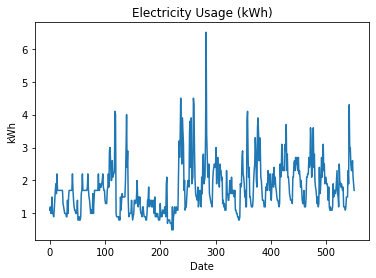

In [4]:
plt.title('Electricity Usage (kWh)')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.plot(master['Usage (kWh)'])
plt.show()

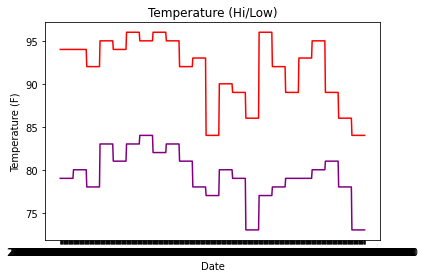

In [11]:
plt.title('Temperature (Hi/Low)')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.plot(master['Hi'], color = 'red')
plt.plot(master['Low'], color = 'purple')
plt.show()

In [12]:
round(np.sum(master['Cost ($)']), 2)

116.25

## database authentication
From AWS docs: https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/UsingWithRDS.IAMDBAuth.Connecting.Python.html

In [13]:
os.chdir(base)

with open('db_creds.json', 'r') as f:
    db_creds = json.load(f)

In [14]:
os.environ['LIBMYSQL_ENABLE_CLEARTEXT_PLUGIN'] = '1'

#gets the credentials from .aws/credentials
session = boto3.Session(region_name = 'us-east-2')
client = boto3.client('rds', region_name = 'us-east-2')

In [15]:
client.list_tags_for_resource(ResourceName = db_creds['DBInstanceArn'])['TagList'][0]

{'Key': 'service', 'Value': 'reliant-energy'}

## database connection

In [33]:
data_table = rs.mysql_query('SELECT * FROM reliant_energy_db.daily_use', db_creds)

In [34]:
display(data_table)

,Date,Usage (kWh),Cost ($),Hi,Low
0,2020-08-25 00:00:00,1.1,0.13,94,79
1,2020-08-25 01:00:00,1.2,0.14,94,79
2,2020-08-25 02:00:00,1.0,0.12,94,79
3,2020-08-25 03:00:00,1.0,0.12,94,79
4,2020-08-25 04:00:00,1.5,0.18,94,79
...,...,...,...,...,...
547,2020-09-19 19:00:00,2.3,0.28,84,73
548,2020-09-19 20:00:00,2.6,0.31,84,73
549,2020-09-19 21:00:00,2.1,0.25,84,73
550,2020-09-19 22:00:00,1.9,0.22,84,73


In [20]:
#data_table.to_csv('data_table_test.csv', index = False)
#print('exported table to .csv')

exported table to .csv


## subset and insert

In [56]:
new2 = pd.read_csv('daily_usage_09212020.csv')
new2.Date = pd.to_datetime(new2.Date)
new2

,Date,Usage (kWh),Cost ($),Hi,Low
0,2020-09-14 00:00:00,2.1,0.25,89,79
1,2020-09-14 01:00:00,1.8,0.22,89,79
2,2020-09-14 02:00:00,1.7,0.20,89,79
3,2020-09-14 03:00:00,1.5,0.18,89,79
4,2020-09-14 04:00:00,1.4,0.17,89,79
...,...,...,...,...,...
139,2020-09-19 19:00:00,2.3,0.28,84,73
140,2020-09-19 20:00:00,2.6,0.31,84,73
141,2020-09-19 21:00:00,2.1,0.25,84,73
142,2020-09-19 22:00:00,1.9,0.22,84,73


In [57]:
pd.concat([data_table, new2]).reset_index(drop = True)

,Date,Usage (kWh),Cost ($),Hi,Low
0,2020-08-25 00:00:00,1.1,0.13,94,79
1,2020-08-25 01:00:00,1.2,0.14,94,79
2,2020-08-25 02:00:00,1.0,0.12,94,79
3,2020-08-25 03:00:00,1.0,0.12,94,79
4,2020-08-25 04:00:00,1.5,0.18,94,79
...,...,...,...,...,...
691,2020-09-19 19:00:00,2.3,0.28,84,73
692,2020-09-19 20:00:00,2.6,0.31,84,73
693,2020-09-19 21:00:00,2.1,0.25,84,73
694,2020-09-19 22:00:00,1.9,0.22,84,73


In [58]:
merge = pd.concat([data_table, new2]).reset_index(drop = True)

In [59]:
merge.drop_duplicates(keep = False, inplace = True)
merge.shape

(408, 5)

In [60]:
new = pd.read_csv('daily_usage_09252020.csv')
new.Date = pd.to_datetime(new.Date)
new

,Date,Usage (kWh),Cost ($),Hi,Low
0,2020-09-21 00:00:00,1.4,0.17,75,71
1,2020-09-21 01:00:00,0.9,0.11,75,71
2,2020-09-21 02:00:00,0.7,0.09,75,71
3,2020-09-21 03:00:00,0.8,0.09,75,71
4,2020-09-21 04:00:00,0.8,0.10,75,71
...,...,...,...,...,...
91,2020-09-24 19:00:00,1.4,0.17,74,70
92,2020-09-24 20:00:00,1.5,0.18,74,70
93,2020-09-24 21:00:00,1.5,0.17,74,70
94,2020-09-24 22:00:00,1.4,0.17,74,70


## table metadata

In [35]:
result = rs.mysql_query('SELECT MIN(Date) as min_date, MAX(Date) as max_date, COUNT(*) as count FROM reliant_energy_db.daily_use', db_creds)

In [36]:
result

,min_date,max_date,count
0,2020-08-25,2020-09-19 23:00:00,552


In [8]:
print('found data range of {} to {} with {} records.'.format(result.min_date[0], result.max_date[0], result['count'][0]))

found data range of 2020-08-25 00:00:00 to 2020-09-17 23:00:00 with 960 records.


## read master data

so date isn't an index.

In [29]:
os.chdir(data)
master = pd.read_csv('master_energy_usage_092520.csv')
master.Date = pd.to_datetime(master.Date)
#master = master['Date', 'Usage (kWh)', 'Cost ($)', 'Hi', 'Low']
print(master.shape)
master.head()

(552, 5)


,Date,Usage (kWh),Cost ($),Hi,Low
0,2020-08-25 00:00:00,1.1,0.13,94,79
1,2020-08-25 01:00:00,1.2,0.14,94,79
2,2020-08-25 02:00:00,1.0,0.12,94,79
3,2020-08-25 03:00:00,1.0,0.12,94,79
4,2020-08-25 04:00:00,1.5,0.18,94,79


In [28]:
master.dtypes

Date           datetime64[ns]
Usage (kWh)           float64
Cost ($)              float64
Hi                      int64
Low                     int64
dtype: object

## upload data
https://stackoverflow.com/questions/10154633/load-csv-data-into-mysql-in-python

In [30]:
rs.table_upload(master, 'reliant_energy_db', 'daily_use', db_creds)

wrote df to sql table.
